In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from pandas import Series 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
%matplotlib inline

## **1. Data Processing**

In [33]:
timeseries_path = os.path.join(os.getcwd(), "drive", "MyDrive",  "timeseries_transformed.csv")
timeseries = pd.read_csv(timeseries_path)

timeseries["time"] = pd.to_datetime(timeseries["time"])
ts=timeseries
ts=ts.set_index('time')
ts_resample= pd.DataFrame()
ts_resample['n_drive_1Day'] = ts.groupby('zone').n_drive_unique.resample('1D').max()
ts_resample.reset_index(inplace = True)
ts_resample


,zone,time,n_drive_1Day
0,0,2019-01-01,15.0
1,0,2019-01-02,7.0
2,0,2019-01-03,14.0
3,0,2019-01-04,15.0
4,0,2019-01-05,17.0
...,...,...,...
146621,438,2019-11-26,0.0
146622,438,2019-11-27,0.0
146623,438,2019-11-28,0.0
146624,438,2019-11-29,0.0


In [34]:
minmax_scaler = MinMaxScaler()
sc = minmax_scaler.fit_transform(ts_resample[['n_drive_1Day']])

data = pd.DataFrame(sc, columns = ['n_drive_1day'], index= ts_resample.index)

data

,n_drive_1day
0,0.223881
1,0.104478
2,0.208955
3,0.223881
4,0.253731
...,...
146621,0.000000
146622,0.000000
146623,0.000000
146624,0.000000


In [35]:
data_merge = pd.merge(ts_resample, data, how='left', on=ts_resample.index)

In [36]:
ts_resample22= data_merge
for s in range(1,50):
  ts_resample22['shifted_{}'.format(s)] = ts_resample22.groupby('zone').n_drive_1day.shift(s)
ts_resample22

,key_0,zone,time,n_drive_1Day,n_drive_1day,shifted_1,shifted_2,shifted_3,shifted_4,shifted_5,shifted_6,shifted_7,shifted_8,shifted_9,shifted_10,shifted_11,shifted_12,shifted_13,shifted_14,shifted_15,shifted_16,shifted_17,shifted_18,shifted_19,shifted_20,shifted_21,shifted_22,shifted_23,shifted_24,shifted_25,shifted_26,shifted_27,shifted_28,shifted_29,shifted_30,shifted_31,shifted_32,shifted_33,shifted_34,shifted_35,shifted_36,shifted_37,shifted_38,shifted_39,shifted_40,shifted_41,shifted_42,shifted_43,shifted_44,shifted_45,shifted_46,shifted_47,shifted_48,shifted_49
0,0,0,2019-01-01,15.0,0.223881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,2019-01-02,7.0,0.104478,0.223881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2019-01-03,14.0,0.208955,0.104478,0.223881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,2019-01-04,15.0,0.223881,0.208955,0.104478,0.223881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,2019-01-05,17.0,0.253731,0.223881,0.208955,0.104478,0.223881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146621,146621,438,2019-11-26,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146622,146622,438,2019-11-27,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146623,146623,438,2019-11-28,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146624,146624,438,2019-11-29,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:

ts_resamplse22 = ts_resample22.dropna().drop(['n_drive_1Day'],1).reset_index(inplace=False)
ts_resamplse22

,index,key_0,zone,time,n_drive_1day,shifted_1,shifted_2,shifted_3,shifted_4,shifted_5,shifted_6,shifted_7,shifted_8,shifted_9,shifted_10,shifted_11,shifted_12,shifted_13,shifted_14,shifted_15,shifted_16,shifted_17,shifted_18,shifted_19,shifted_20,shifted_21,shifted_22,shifted_23,shifted_24,shifted_25,shifted_26,shifted_27,shifted_28,shifted_29,shifted_30,shifted_31,shifted_32,shifted_33,shifted_34,shifted_35,shifted_36,shifted_37,shifted_38,shifted_39,shifted_40,shifted_41,shifted_42,shifted_43,shifted_44,shifted_45,shifted_46,shifted_47,shifted_48,shifted_49
0,49,49,0,2019-02-19,0.253731,0.253731,0.283582,0.417910,0.253731,0.179104,0.283582,0.283582,0.253731,0.223881,0.253731,0.179104,0.208955,0.313433,0.701493,0.611940,0.402985,0.373134,0.253731,0.343284,0.343284,0.253731,0.208955,0.194030,0.298507,0.194030,0.194030,0.223881,0.223881,0.208955,0.223881,0.223881,0.208955,0.194030,0.268657,0.223881,0.164179,0.238806,0.313433,0.208955,0.164179,0.119403,0.253731,0.149254,0.208955,0.253731,0.223881,0.208955,0.104478,0.223881
1,50,50,0,2019-02-20,0.388060,0.253731,0.253731,0.283582,0.417910,0.253731,0.179104,0.283582,0.283582,0.253731,0.223881,0.253731,0.179104,0.208955,0.313433,0.701493,0.611940,0.402985,0.373134,0.253731,0.343284,0.343284,0.253731,0.208955,0.194030,0.298507,0.194030,0.194030,0.223881,0.223881,0.208955,0.223881,0.223881,0.208955,0.194030,0.268657,0.223881,0.164179,0.238806,0.313433,0.208955,0.164179,0.119403,0.253731,0.149254,0.208955,0.253731,0.223881,0.208955,0.104478
2,51,51,0,2019-02-21,0.298507,0.388060,0.253731,0.253731,0.283582,0.417910,0.253731,0.179104,0.283582,0.283582,0.253731,0.223881,0.253731,0.179104,0.208955,0.313433,0.701493,0.611940,0.402985,0.373134,0.253731,0.343284,0.343284,0.253731,0.208955,0.194030,0.298507,0.194030,0.194030,0.223881,0.223881,0.208955,0.223881,0.223881,0.208955,0.194030,0.268657,0.223881,0.164179,0.238806,0.313433,0.208955,0.164179,0.119403,0.253731,0.149254,0.208955,0.253731,0.223881,0.208955
3,52,52,0,2019-02-22,0.268657,0.298507,0.388060,0.253731,0.253731,0.283582,0.417910,0.253731,0.179104,0.283582,0.283582,0.253731,0.223881,0.253731,0.179104,0.208955,0.313433,0.701493,0.611940,0.402985,0.373134,0.253731,0.343284,0.343284,0.253731,0.208955,0.194030,0.298507,0.194030,0.194030,0.223881,0.223881,0.208955,0.223881,0.223881,0.208955,0.194030,0.268657,0.223881,0.164179,0.238806,0.313433,0.208955,0.164179,0.119403,0.253731,0.149254,0.208955,0.253731,0.223881
4,53,53,0,2019-02-23,0.283582,0.268657,0.298507,0.388060,0.253731,0.253731,0.283582,0.417910,0.253731,0.179104,0.283582,0.283582,0.253731,0.223881,0.253731,0.179104,0.208955,0.313433,0.701493,0.611940,0.402985,0.373134,0.253731,0.343284,0.343284,0.253731,0.208955,0.194030,0.298507,0.194030,0.194030,0.223881,0.223881,0.208955,0.223881,0.223881,0.208955,0.194030,0.268657,0.223881,0.164179,0.238806,0.313433,0.208955,0.164179,0.119403,0.253731,0.149254,0.208955,0.253731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125110,146621,146621,438,2019-11-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
125111,146622,146622,438,2019-11-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

## **2. Data split**

In [38]:
train = ts_resamplse22.query("time <= '2019-09-30 23:00:00'")
test = ts_resamplse22.query("time > '2019-09-30 23:00:00'")

x_train = np.asarray(train.drop(['n_drive_1day', 'time'],1), dtype = np.float32)
y_train = np.asarray(train[['n_drive_1day']], dtype = np.float32)
x_test = np.asarray(test.drop(['n_drive_1day', 'time'],1), dtype = np.float32)
y_test = np.asarray(test[['n_drive_1day']], dtype = np.float32)


In [39]:
x_test.shape

(26779, 52)

In [40]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_train.shape

(98336, 52, 1)

In [41]:
y_train.shape

(98336, 1)

## **3. Model Adjustment**

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [43]:

my_LSTM_model = Sequential()
my_LSTM_model.add(LSTM(units = 20, 
                           return_sequences = True, 
                           input_shape = (52,1), 
                           activation = 'tanh'))
my_LSTM_model.add(LSTM(units = 52, activation = 'tanh'))
my_LSTM_model.add(Dense(units=2))
    
    # Compiling 
my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mean_squared_error')
    
    # Fitting to the training set 
my_LSTM_model.fit(x_train, y_train, epochs = 30, batch_size = 150, verbose = 1, shuffle=False)
    
LSTM_prediction = my_LSTM_model.predict(x_test)

print(LSTM_prediction)




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
656/656 [==============================] - 62s 89ms/step - loss: 0.0016
Epoch 2/30
656/656 [==============================] - 57s 88ms/step - loss: 0.0010
Epoch 3/30
656/656 [==============================] - 58s 88ms/step - loss: 5.8130e-04
Epoch 4/30
656/656 [==============================] - 57s 87ms/step - loss: 3.8791e-04
Epoch 5/30
656/656 [==============================] - 57s 87ms/step - loss: 3.5092e-04
Epoch 6/30
656/656 [==============================] - 57s 87ms/step - loss: 3.4444e-04
Epoch 7/30
656/656 [==============================] - 57s 88ms/step - loss: 3.4217e-04
Epoch 8/30
656/656 [==============================] - 60s 91ms/step - loss: 3.4054e-04
Epoch 9/30
656/656 [==============================] - 57s 86ms/step - loss: 3.3904e-04
Epoch 10/30
656/656 [==============================] - 57s 87ms/step - loss: 3.3758e-04
Epoch 11/30
656/656 [==============================] - 57s 87ms/step - loss: 3.3615e-04
Epoch 12/30
656/656 [============================

In [44]:
LSTM_prediction1 = LSTM_prediction.mean(axis=1)
LSTM_prediction1.shape
LSTM_prediction1.reshape(26779,1)

array([[0.54592776],
       [0.54230034],
       [0.53879666],
       ...,
       [0.00202433],
       [0.00202433],
       [0.00202433]], dtype=float32)

In [45]:
y_test2 = minmax_scaler.inverse_transform(y_test)
LSTM_prediction2 = minmax_scaler.inverse_transform(LSTM_prediction)

In [46]:
LSTM_prediction2
LSTM_prediction1 = LSTM_prediction2.mean(axis=1)
LSTM_prediction1.reshape(26779,1)

array([[36.57716   ],
       [36.334126  ],
       [36.09938   ],
       ...,
       [ 0.13562988],
       [ 0.13562988],
       [ 0.13562988]], dtype=float32)

## **4. Model Evaluation**

In [47]:
mse = mean_squared_error(y_test2, LSTM_prediction1)
mse


1.3955466

In [48]:
 import matplotlib.pyplot as plt



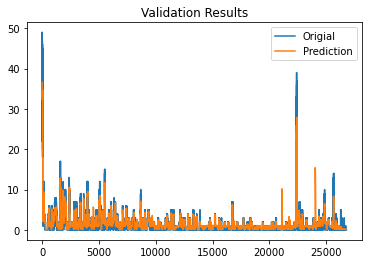

In [49]:
  plt.plot(y_test2, label='Origial')
  plt.plot(LSTM_prediction1, label='Prediction')
  plt.legend(loc=0)
  plt.title('Validation Results')
  plt.show()